## GPT/Claude based Schematic component recognition

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "image_path": "complex_RC.jpg",
  "prompt": "\n   Given the image which contains a circuit schematic drawing, provide the following information:\n   - A count of how many components are in the image\n   - A list of wires present on this schematic drawing, including start and end position on the image (you may approaximate using pixel locations)\n   - A list of components present on this schematic drawing, including their name, position on the image, and orientation (you may approaximate using pixel locations)\n   - A list of connections made by the components, you must make sure all the referneces stays consistent throught your answer!\n   Please just reply ONLY in JSON output and nothing else!\n   "
}
[chain/start] [1:chain:RunnableSequence > 2:chain:TransformChain] Entering Chain run with input:
{
  "image_path": "complex_RC.jpg",
  "prompt": "\n   Given the image which contains a circuit schematic drawing, p
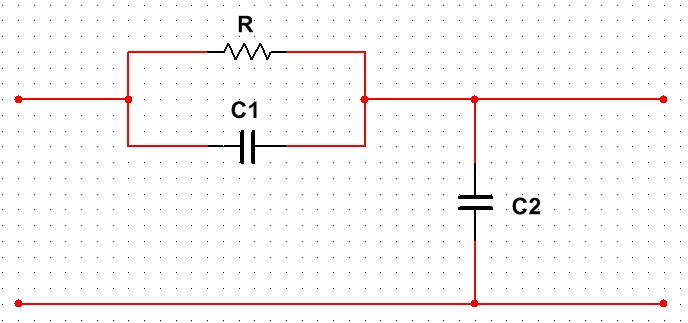

In [58]:
from LLMToSchematics import image_to_schematics

result= image_to_schematics("complex_RC.jpg")

# GPT Output processing

In [73]:
# save the result

# save the result dictionary to a file
import json
with open('result.json', 'w') as f:
    json.dump(result, f, indent=4)




In [74]:
# load the dictionary from the file
import json
with open('result.json', 'r') as f:
    result = json.load(f)

In [75]:
# iterate through the list of dicts results and remove empty dicts
for i in range(len(result['detected_components'])):
    if not result['detected_components'][i]:
        del result['detected_components'][i]
for component in result["detected_components"]:
    print(component["lib_id"])

resistor
capacitor
capacitor


In [76]:
import kicad_utils
kicad_schematic_path = "testProject/testProject.kicad_sch"
list_of_component_dict =[]


for symbol in result["detected_components"]:
    print(symbol["lib_id"], symbol["x"], symbol["y"], symbol["angle"], symbol["reference"])
    
    # Add the component to the list
    list_of_component_dict.append({"lib_id": kicad_utils.match_libId(symbol["lib_id"]), "x": symbol["x"], "y": symbol["y"], "angle": symbol["angle"], "reference_name": symbol["reference"]})


    

resistor 80 20 0 R
capacitor 80 110 90 C1
capacitor 160 75 0 C2


In [77]:
import kicad_utils
kicad_utils.modify_kicad_sch_file(components = list_of_component_dict, file_path=kicad_schematic_path)

Modified file testProject/testProject.kicad_sch


'(kicad_sch\n\t(version 20231120)\n\t(generator "eeschema")\n\t(generator_version "8.0")\n\t(uuid "dea647a7-e0d8-45e4-9bce-23c7e387cf2b")\n\t(paper "A4")\n\t(lib_symbols\n (symbol "Device:C"\n\t\t(pin_numbers hide)\n\t\t(pin_names\n\t\t\t(offset 0.254)\n\t\t)\n\t\t(exclude_from_sim no)\n\t\t(in_bom yes)\n\t\t(on_board yes)\n\t\t(property "Reference" "C"\n\t\t\t(at 0.635 2.54 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(justify left)\n\t\t\t)\n\t\t)\n\t\t(property "Value" "C"\n\t\t\t(at 0.635 -2.54 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(justify left)\n\t\t\t)\n\t\t)\n\t\t(property "Footprint" ""\n\t\t\t(at 0.9652 -3.81 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(hide yes)\n\t\t\t)\n\t\t)\n\t\t(property "Datasheet" "~"\n\t\t\t(at 0 0 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(hide yes)\n\t\t\t)\n\t\t)\n\t\t(property "Description"

In [50]:
# kicad_utils.modify_kicad_sch_file(wires= result['detected_wires'], file_path=kicad_schematic_path)

In [78]:
for connection in result["component_connections"]:
    print(connection['componentA_reference'], connection['componentA_pin'], connection['componentB_reference'], connection['componentB_pin'])

    

R 1 C1 1
R 2 C2 1
C1 2 C2 2


In [52]:
# code which maps R2.1 to x and y position


# THIS IS THE MOST IMPORTANT CELL

In [79]:
# result["component_connections"][0]['componentA_reference']
import skip
schem = skip.Schematic("testProject/testProject.kicad_sch")
wire_list = []

for symbol in schem.symbol:
    print(symbol.property.Reference.value)
    


C2
C1
R


In [80]:
def find_component_in_schem(component_reference, skip_schematic):
    for symbol in skip_schematic.symbol:
        if symbol.property.Reference.value == component_reference:
            return symbol
found_symbol = find_component_in_schem("C1", schem)
print(found_symbol)
print(found_symbol.pin[0].location.x)

  <symbol C1>
    lib_id = Device:C

      <at [80, 110, 90]>

      unit = 1

      exclude_from_sim = False

      in_bom = True

      on_board = True

      dnp = False

      fields_autoplaced = True

      uuid = e7dd9878-b2c9-4ba...

      Reference:
    <property ['Reference', ...
      <at [80, 110, 0]>

          effects = [font = [<size...
        font = [<size [1.27, 1.2...
          <size [1.27, 1.27]>

    Value:
    <property ['Value', '']>
      <at [80, 110, 0]>

          effects = [font = [<size...
        font = [<size [1.27, 1.2...
          <size [1.27, 1.27]>

    Footprint:
    <property ['Footprint', ...
      <at [80, 110, 0]>

          <effects [font = [<size ...
        font = [<size [1.27, 1.2...
          <size [1.27, 1.27]>

              hide = True

    Datasheet:
    <property ['Datasheet', ...
      <at [80, 110, 0]>

          <effects [font = [<size ...
        font = [<size [1.27, 1.2...
          <size [1.27, 1.27]>

              hide = True

  

In [81]:
# Pseudo code
import skip
schem = skip.Schematic("testProject/testProject.kicad_sch")
wire_list = []


# make a copy of detected connections
all_connections = result["component_connections"].copy()

# Iterate through the list of generated components in kicad shematic
for curr_component in schem.symbol:
    print(curr_component.property.Reference.value)
    curr_component_ref = curr_component.property.Reference.value
#   iterate through the list of detected connections
    for curr_connection in all_connections:
        # if curr component is compA in curr connection
        if curr_connection['componentA_reference'] == curr_component_ref:
            curr_component_A_pin = curr_component.pin[curr_connection['componentA_pin']-1]
            #find component B
            curr_component_B = find_component_in_schem(curr_connection['componentB_reference'], schem)
            curr_component_B_pin = curr_component_B.pin[curr_connection['componentB_pin']-1]
            # add a wire to connect
            wire_list.append({"x": curr_component_A_pin.location.x, "y": curr_component_A_pin.location.y, "end_x": curr_component_B_pin.location.x, "end_y":curr_component_B_pin.location.y})

print("Wire List")


C2
C1
R
Wire List


In [82]:
print(wire_list)

def split_diagonal_segments(wire_list):
    new_wire_list = []
    for segment in wire_list:
        # Check if the segment is diagonal
        if segment['x'] != segment['end_x'] and segment['y'] != segment['end_y']:
            # Split the diagonal segment into horizontal and vertical segments
            horizontal_segment = {'x': segment['x'], 'y': segment['y'], 'end_x': segment['end_x'], 'end_y': segment['y']}
            vertical_segment = {'x': segment['end_x'], 'y': segment['y'], 'end_x': segment['end_x'], 'end_y': segment['end_y']}
            new_wire_list.append(horizontal_segment)
            new_wire_list.append(vertical_segment)
        else:
            new_wire_list.append(segment)  # Keep non-diagonal segments unchanged
    return new_wire_list


new_wire_list = split_diagonal_segments(wire_list)
print(new_wire_list)

[{'x': 76.19, 'y': 110, 'end_x': 160, 'end_y': 78.81}, {'x': 80, 'y': 16.19, 'end_x': 83.81, 'end_y': 110}, {'x': 80, 'y': 23.81, 'end_x': 160, 'end_y': 71.19}]
[{'x': 76.19, 'y': 110, 'end_x': 160, 'end_y': 110}, {'x': 160, 'y': 110, 'end_x': 160, 'end_y': 78.81}, {'x': 80, 'y': 16.19, 'end_x': 83.81, 'end_y': 16.19}, {'x': 83.81, 'y': 16.19, 'end_x': 83.81, 'end_y': 110}, {'x': 80, 'y': 23.81, 'end_x': 160, 'end_y': 23.81}, {'x': 160, 'y': 23.81, 'end_x': 160, 'end_y': 71.19}]


In [84]:
import kicad_utils
kicad_schematic_path = "testProject/testProject.kicad_sch"
kicad_utils.modify_kicad_sch_file(wires= new_wire_list, file_path=kicad_schematic_path)

Modified file testProject/testProject.kicad_sch


'(kicad_sch\n\t(version 20231120)\n\t(generator "eeschema")\n\t(generator_version "8.0")\n\t(uuid "dea647a7-e0d8-45e4-9bce-23c7e387cf2b")\n\t(paper "A4")\n\t(lib_symbols\n\t\t(symbol "Device:C"\n\t\t\t(pin_numbers hide)\n\t\t\t(pin_names\n\t\t\t\t(offset 0.254)\n\t\t\t)\n\t\t\t(exclude_from_sim no)\n\t\t\t(in_bom yes)\n\t\t\t(on_board yes)\n\t\t\t(property "Reference" "C"\n\t\t\t\t(at 0.635 2.54 0)\n\t\t\t\t(effects\n\t\t\t\t\t(font\n\t\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t\t)\n\t\t\t\t\t(justify left)\n\t\t\t\t)\n\t\t\t)\n\t\t\t(property "Value" "C"\n\t\t\t\t(at 0.635 -2.54 0)\n\t\t\t\t(effects\n\t\t\t\t\t(font\n\t\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t\t)\n\t\t\t\t\t(justify left)\n\t\t\t\t)\n\t\t\t)\n\t\t\t(property "Footprint" ""\n\t\t\t\t(at 0.9652 -3.81 0)\n\t\t\t\t(effects\n\t\t\t\t\t(font\n\t\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t\t)\n\t\t\t\t\t(hide yes)\n\t\t\t\t)\n\t\t\t)\n\t\t\t(property "Datasheet" "~"\n\t\t\t\t(at 0 0 0)\n\t\t\t\t(effects\n\t\t\t\t\t(font\n\t\t\t\t\t\t(size 1.27 

In [29]:
# find a symbol by reference "R1" using skip library


schem.symbol

<Collection [<symbol C1>, <symbol D1>]>

In [30]:
import skip
schem = skip.Schematic("testProject/testProject.kicad_sch")
wire_list = []


print(schem.symbol[0].pin[0].location.x)

283.81


In [31]:
wire_list = []
wire_list.append({"x": 121.92, "y": 67.31, "end_x": 156.21, "end_y": 67.31})
wire_list.append({"x": 1221.92, "y": 672.31, "end_x": 156.21, "end_y": 67.31})

print(wire_list)

[{'x': 121.92, 'y': 67.31, 'end_x': 156.21, 'end_y': 67.31}, {'x': 1221.92, 'y': 672.31, 'end_x': 156.21, 'end_y': 67.31}]


In [32]:

for connection in result["component_connections"]:
    wire_list.append({"x":"", "y": 67.31, "end_x": 156.21, "end_y": 67.31})
    

for component in schem.symbol:
    print(component.pin[0].location.x)


283.81
96.19


In [33]:
import kicad_utils
temp_file_path = "testProject/testProject.kicad_sch"

temp_components = [
    # {"lib_id": ":SW_DPST_x2", "x": 143.51, "y": 77.47, "angle":0, "reference_name": "SW1A"},
    # {"lib_id": "Device:Ammeter_AC", "x": 133.35, "y": 64.77, "angle":0, "reference_name": "BT1"},
    # {"lib_id": "Device:Ammeter_AC", "x": 133.35, "y": 64.77, "angle":0, "reference_name": "BT1"},
    {"lib_id": "Device:R", "x": 146.05, "y": 53.34, "angle":90, "reference_name": "R1"}
]

# kicad_utils.extract_symbol_definition("Device:R")
# kicad_utils.modify_kicad_sch_file(components = temp_components, file_path=temp_file_path)
kicad_utils.create_kicad_sch_file(components = temp_components,)


Created file temp_7067e852-db20-4460-a3d6-16a41af6c8cd.kicad_sch


'temp_7067e852-db20-4460-a3d6-16a41af6c8cd.kicad_sch'

## Try adding wires


In [43]:
import skip


# load a schematic
schem = skip.Schematic("testProject/testProject.kicad_sch")


In [49]:
# # print(schem.symbol.R1.location)
# for component in schem.symbol:
    
#     print(component.value)

print(schem.symbol.R3.pin[0].location.x)
    # print(type(component))

114.3
